In [1]:
import os
import time
import streamlit as st
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
from docx import Document
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema import Document as LangchainDocument
from langchain_ollama import ChatOllama, OllamaEmbeddings

from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct
from langgraph.graph import StateGraph, END

# ✅ 1. Khởi tạo kết nối Qdrant
QDRANT_HOST = "10.100.140.54"
QDRANT_PORT = 6333

def get_qdrant_client():
    return QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)

# ✅ 2. Định nghĩa trạng thái chatbot
class ChatbotState(dict):
    uploaded_files: list
    question: str
    chat_history: list
    retrieved_context: str
    response: str

# ✅ 3. Load và tách nội dung từ các loại file
def load_and_split_pdf(file_path, chunk_size=600, chunk_overlap=50):
    from langchain.document_loaders import PyMuPDFLoader
    loader = PyMuPDFLoader(file_path)
    documents = loader.load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(documents)

def load_and_split_docx(file_path, chunk_size=1000, chunk_overlap=100):
    doc = Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs if para.text.strip()])
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)

def load_and_split_csv(file_path, chunk_size=1000, chunk_overlap=100):
    df = pd.read_csv(file_path)
    text = "\n".join(df.astype(str).apply(lambda x: " ".join(x), axis=1))
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)

def load_and_split_excel(file_path, chunk_size=1000, chunk_overlap=100):
    df = pd.read_excel(file_path)
    text = "\n".join(df.astype(str).apply(lambda x: " ".join(x), axis=1))
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)

# ✅ 4. Xử lý file tải lên
def process_uploaded_files(state: ChatbotState):
    if not state["uploaded_files"]:
        return {"retrieved_context": ""}

    qdrant_client = get_qdrant_client()
    embeddings = OllamaEmbeddings(model="nomic-embed-text", base_url="http://localhost:11434")

    collection_name = "document_chunks"
    existing_collections = [col.name for col in qdrant_client.get_collections().collections]

    if collection_name not in existing_collections:
        qdrant_client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=len(embeddings.embed_query("sample text")), distance=Distance.COSINE)
        )

    doc_chunks = []
    for file in state["uploaded_files"]:
        temp_path = Path(f"temp_{file.name}")
        with temp_path.open("wb") as f:
            f.write(file.read())

        if file.name.endswith(".pdf"):
            doc_chunks.extend(load_and_split_pdf(str(temp_path)))
        elif file.name.endswith(".docx"):
            doc_chunks.extend(load_and_split_docx(str(temp_path)))
        elif file.name.endswith(".csv"):
            doc_chunks.extend(load_and_split_csv(str(temp_path)))
        elif file.name.endswith(".xlsx"):
            doc_chunks.extend(load_and_split_excel(str(temp_path)))

        temp_path.unlink()

    vectors = [embeddings.embed_query(chunk.page_content) for chunk in doc_chunks]
    payloads = [{"id": i, "text": chunk.page_content} for i, chunk in enumerate(doc_chunks)]
    points = [PointStruct(id=i, vector=vectors[i], payload=payloads[i]) for i in range(len(vectors))]

    def upsert_batch(batch):
        qdrant_client.upsert(collection_name=collection_name, points=batch)

    with ThreadPoolExecutor() as executor:
        executor.map(upsert_batch, [points[i:i + 100] for i in range(0, len(points), 100)])

    return {"retrieved_context": "Documents processed and indexed!"}

# ✅ 5. Truy vấn dữ liệu từ Qdrant
def retrieve_context(state: ChatbotState):
    qdrant_client = get_qdrant_client()
    embeddings = OllamaEmbeddings(model="nomic-embed-text", base_url="http://localhost:11434")
    
    query_vector = embeddings.embed_query(state["question"])
    search_result = qdrant_client.search(collection_name="document_chunks", query_vector=query_vector, limit=3)
    
    retrieved_text = "\n\n".join(hit.payload["text"] for hit in search_result)
    return {"retrieved_context": retrieved_text}

# ✅ 6. Tạo chatbot trả lời
def generate_response(state: ChatbotState):
    chat_model = ChatOllama(model="mistral", base_url="http://localhost:11434")

    prompt_text = f"""
    You are an AI assistant named Detnam.
    Conversation history: {state["chat_history"]}
    New question: {state["question"]}
    Retrieved context: {state["retrieved_context"]}

    Answer the question based on the retrieved context. If the context is empty, use general knowledge.
    """
    
    response = chat_model.invoke(prompt_text).content
    return {"response": response}

# ✅ 7. Xây dựng workflow LangGraph
workflow = StateGraph(ChatbotState)

workflow.add_node("process_uploaded_files", process_uploaded_files)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("generate_response", generate_response)

workflow.set_entry_point("process_uploaded_files")
workflow.add_edge("process_uploaded_files", "retrieve_context")
workflow.add_edge("retrieve_context", "generate_response")
workflow.add_edge("generate_response", END)

graph = workflow.compile()




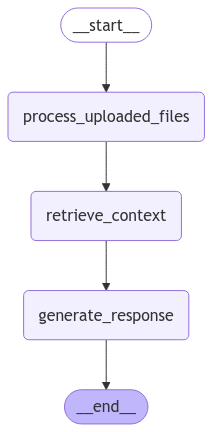

In [2]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [1]:
import os
import json
import time
import hashlib
import requests
import streamlit as st
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
from docx import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema import Document as LangchainDocument
from langchain_ollama import ChatOllama, OllamaEmbeddings

from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct
from langgraph.graph import StateGraph, END

# 1. Cấu hình và khởi tạo
QDRANT_HOST = "10.100.140.54"
QDRANT_PORT = 6333
OLLAMA_BASE_URL = "http://localhost:11434"
MODEL_NAME_EMBEDDING = "nomic-embed-text"
MODEL_NAME_LLM = "deepseek-r1:14b"
COLLECTION_NAME = "test-rag"

def get_qdrant_client():
    return QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
class ChatbotState(dict):
    uploaded_files: List[Any]
    question: str
    chat_history: List[Dict[str, str]]
    retrieved_context: str
    response: str
    tool_response: Optional[Dict[str, Any]]

def retrieve_context(state: ChatbotState):
    qdrant_client = get_qdrant_client()
    embeddings = OllamaEmbeddings(model=MODEL_NAME_EMBEDDING, base_url="http://localhost:11434")
    
    query_vector = embeddings.embed_query(state["question"])
    search_result = qdrant_client.search(collection_name=COLLECTION_NAME, query_vector=query_vector, limit=3)
    
    retrieved_text = "\n\n".join(hit.payload["text"] for hit in search_result)
    return {"retrieved_context": retrieved_text}

def load_and_split_pdf(file_path, chunk_size=600, chunk_overlap=50):
    from langchain.document_loaders import PyMuPDFLoader
    loader = PyMuPDFLoader(file_path)
    documents = loader.load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(documents)

def load_and_split_docx(file_path, chunk_size=1000, chunk_overlap=100):
    doc = Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs if para.text.strip()])
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)

def load_and_split_csv(file_path, chunk_size=1000, chunk_overlap=100):
    df = pd.read_csv(file_path)
    text = "\n".join(df.astype(str).apply(lambda x: " ".join(x), axis=1))
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)

def load_and_split_excel(file_path, chunk_size=1000, chunk_overlap=100):
    df = pd.read_excel(file_path)
    text = "\n".join(df.astype(str).apply(lambda x: " ".join(x), axis=1))
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_text(text)

# ✅ 4. Xử lý file tải lên
def process_uploaded_files(state: ChatbotState):
    if not state["uploaded_files"]:
        return {"retrieved_context": ""}

    qdrant_client = get_qdrant_client()
    embeddings = OllamaEmbeddings(model=MODEL_NAME_EMBEDDING, base_url="http://localhost:11434")

    collection_name = COLLECTION_NAME
    existing_collections = [col.name for col in qdrant_client.get_collections().collections]

    if collection_name not in existing_collections:
        qdrant_client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=len(embeddings.embed_query("sample text")), distance=Distance.COSINE)
        )

    doc_chunks = []
    for file in state["uploaded_files"]:
        temp_path = Path(f"temp_{file.name}")
        with temp_path.open("wb") as f:
            f.write(file.read())

        if file.name.endswith(".pdf"):
            doc_chunks.extend(load_and_split_pdf(str(temp_path)))
        elif file.name.endswith(".docx"):
            doc_chunks.extend(load_and_split_docx(str(temp_path)))
        elif file.name.endswith(".csv"):
            doc_chunks.extend(load_and_split_csv(str(temp_path)))
        elif file.name.endswith(".xlsx"):
            doc_chunks.extend(load_and_split_excel(str(temp_path)))

        temp_path.unlink()

    vectors = [embeddings.embed_query(chunk.page_content) for chunk in doc_chunks]
    payloads = [{"id": i, "text": chunk.page_content} for i, chunk in enumerate(doc_chunks)]
    points = [PointStruct(id=i, vector=vectors[i], payload=payloads[i]) for i in range(len(vectors))]

    def upsert_batch(batch):
        qdrant_client.upsert(collection_name=collection_name, points=batch)

    with ThreadPoolExecutor() as executor:
        executor.map(upsert_batch, [points[i:i + 100] for i in range(0, len(points), 100)])

    return {"retrieved_context": "Documents processed and indexed!"}

# 2. Định nghĩa các công cụ
class ChatTools:
    # Định nghĩa TOOLS như một class variable
    TOOLS = {
        "get_current_time": {
            "function": lambda state: {
                "tool_name": "current_time",
                "content": datetime.now().strftime("%H:%M %d/%m/%Y"),
                "success": True
            },
            "description": "Trả về thời gian hiện tại"
        },
        "web_search": {
            "function": lambda state, query: {
                "tool_name": "web_search",
                "query": query,
                "results": [{"title": "Kết quả mẫu", "content": "Đây là kết quả tìm kiếm giả lập"}],
                "success": True
            },
            "description": "Tìm kiếm thông tin trên web"
        },
        "search_documents": {
            "function": lambda state, query: {
                "tool_name": "document_search",
                "query": query,
                "results": search_documents_in_qdrant(query),
                "success": True
            },
            "description": "Tìm kiếm nâng cao trong tài liệu"
        }
    }

    @classmethod
    def get_tool(cls, tool_name: str) -> Optional[Dict[str, Any]]:
        """Lấy thông tin công cụ theo tên"""
        return cls.TOOLS.get(tool_name)

    @classmethod
    def list_tools(cls) -> List[Dict[str, str]]:
        """Liệt kê danh sách các công cụ có sẵn"""
        return [{"name": name, "description": data["description"]} for name, data in cls.TOOLS.items()]

# Hàm hỗ trợ tìm kiếm tài liệu trong Qdrant
def search_documents_in_qdrant(query: str) -> List[str]:
    try:
        qdrant_client = get_qdrant_client()
        embeddings = OllamaEmbeddings(model="nomic-embed-text", base_url=OLLAMA_BASE_URL)
        
        query_vector = embeddings.embed_query(query)
        search_result = qdrant_client.search(
            collection_name="document_chunks",
            query_vector=query_vector,
            limit=5,
            with_payload=True
        )
        
        return [hit.payload["text"] for hit in search_result]
    except Exception as e:
        return [f"Lỗi tìm kiếm: {str(e)}"]

# Cập nhật ToolHandler
class ToolHandler:
    @classmethod
    def handle_tool_call(cls, state: ChatbotState) -> ChatbotState:
        try:
            tool_response = json.loads(state["response"])
            tool_name = tool_response.get("tool")
            parameters = tool_response.get("parameters", {})
            
            tool_info = ChatTools.get_tool(tool_name)
            if tool_info:
                tool_func = tool_info["function"]
                result = tool_func(state, **parameters)
                state["tool_response"] = result
            else:
                state["tool_response"] = {"error": f"Tool {tool_name} không tồn tại"}
            
            return state
        except json.JSONDecodeError:
            state["tool_response"] = {"error": "Lỗi phân tích cú pháp tool call"}
            return state
        except Exception as e:
            state["tool_response"] = {"error": f"Lỗi thực thi tool: {str(e)}"}
            return state

# 4. Cập nhật prompt template với tool calling
def create_response_chain(with_tools: bool = False):
    # System template với các biến rõ ràng
    system_template = """
    Bạn là **Detnam**, trợ lý AI thông minh. Bạn có thể sử dụng các công cụ sau khi cần:
    
    {tools_list}
    
    ### Nguyên tắc:
    1. Luôn kiểm tra thông tin trong tài liệu trước
    2. Sử dụng công cụ khi cần thông tin thời gian thực/tìm kiếm nâng cao
    3. Định dạng tool call: {{"tool": "tên_công_cụ", "parameters": {{...}}}}
    4. Giữ câu trả lời tự nhiên, thân thiện
    """
    
    # Human template với các biến rõ ràng
    human_template = """
    ### Lịch sử chat:
    {history}
    
    ### Tài liệu tham khảo:
    {context}
    
    ### Câu hỏi:
    {question}
    
    Hãy trả lời câu hỏi hoặc gọi công cụ cần thiết:
    """
    
    # Tạo danh sách công cụ nếu cần
    if with_tools:
        tools_list = "\n".join(
            f"- {tool['name']}: {tool['description']}" 
            for tool in ChatTools.list_tools()
        )
        system_template = system_template.format(tools_list=tools_list)
    
    # Tạo prompt template
    return ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template)
    ]) | ChatOllama(model="deepseek-r1:14b", base_url=OLLAMA_BASE_URL) | StrOutputParser()
    
# 5. Cập nhật workflow LangGraph
def setup_workflow() -> StateGraph:
    workflow = StateGraph(ChatbotState)
    
    workflow.add_node("process_uploaded_files", process_uploaded_files)
    workflow.add_node("retrieve_context", retrieve_context)
    workflow.add_node("generate_initial_response", generate_initial_response)
    workflow.add_node("handle_tool_call", handle_tool_call)
    workflow.add_node("generate_final_response", generate_final_response)
    
    workflow.set_entry_point("process_uploaded_files")
    workflow.add_edge("process_uploaded_files", "retrieve_context")
    workflow.add_edge("retrieve_context", "generate_initial_response")
    
    # Xử lý tool call
    workflow.add_conditional_edges(
        "generate_initial_response",
        lambda state: "tool_call" if is_tool_call(state) else "final_response",
        {
            "tool_call": "handle_tool_call",
            "final_response": END
        }
    )
    workflow.add_edge("handle_tool_call", "generate_final_response")
    workflow.add_edge("generate_final_response", END)
    
    return workflow.compile()

def is_tool_call(state: ChatbotState) -> str:
    try:
        response = state["response"]
        if isinstance(response, str):
            parsed = json.loads(response)
            return "tool_call" if "tool" in parsed else "final_response"
        return "final_response"
    except json.JSONDecodeError:
        return "final_response"

# 6. Cập nhật các hàm xử lý
def generate_initial_response(state: ChatbotState) -> Dict[str, Any]:
    chain = create_response_chain(with_tools=True)
    history = format_history(state["chat_history"])
    
    # Truyền đúng các biến vào prompt template
    response = chain.invoke({
        "context": state["retrieved_context"],
        "history": history,
        "question": state["question"]
    })
    
    return {"response": response}

def handle_tool_call(state: ChatbotState) -> Dict[str, Any]:
    tool_handler = ToolHandler()
    return tool_handler.handle_tool_call(state)

def generate_final_response(state: ChatbotState) -> Dict[str, Any]:
    chain = create_response_chain(with_tools=False)
    history = format_history(state["chat_history"])
    tool_result = json.dumps(state.get("tool_response", {}), ensure_ascii=False)
    
    # Truyền đúng các biến vào prompt template
    response = chain.invoke({
        "context": f"{state['retrieved_context']}\n\nKết quả công cụ: {tool_result}",
        "history": history,
        "question": state["question"]
    })
    
    return {"response": response}

def format_history(history: List[Dict[str, str]]) -> str:
    return "\n".join(
        f"👤 {msg['user']}\n🤖 {msg['bot']}" 
        for msg in history[-3:]  # Giới hạn lịch sử chat
    )
# 8. Giao diện Streamlit
def main():
    st.title("🤖 Detnam Pro - Trợ lý AI với Tool Calling")
    
    if "chat_history" not in st.session_state:
        st.session_state.chat_history = []
    
    uploaded_files = st.file_uploader("Tải lên tài liệu", type=["pdf", "docx", "csv", "xlsx"], accept_multiple_files=True)
    
    for msg in st.session_state.chat_history:
        with st.chat_message("user" if msg.get("user") else "assistant"):
            st.markdown(msg.get("user", msg.get("bot", "")))
    
    if user_input := st.chat_input("Nhập câu hỏi..."):
        st.session_state.chat_history.append({"user": user_input})
        
        chat_state = {
            "uploaded_files": uploaded_files,
            "question": user_input,
            "chat_history": st.session_state.chat_history[:-1],
            "retrieved_context": "",
            "response": "",
            "tool_response": None
        }
        
        try:
            graph = setup_workflow()
            result = graph.invoke(chat_state)
            
            # Hiển thị kết quả công cụ nếu có
            if result.get("tool_response"):
                with st.expander("Chi tiết công cụ đã sử dụng"):
                    st.json(result["tool_response"])
            
            st.session_state.chat_history[-1]["bot"] = result["response"]
            st.rerun()
        except Exception as e:
            st.error(f"Lỗi hệ thống: {str(e)}")


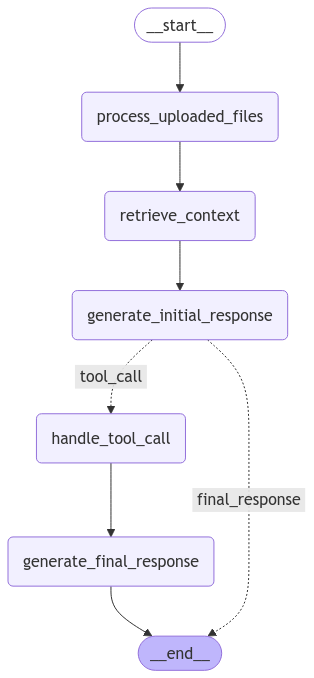

In [4]:
from IPython.display import display, Image
graph = setup_workflow()

display(Image(graph.get_graph().draw_mermaid_png()))